# 🚗 Car Price Prediction

Setup & Imports

In [2]:
!pip install lightgbm xgboost catboost optuna shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.4 MB/s eta 0:00:00


In [3]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge

# Modern ML models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler

# Model interpretability
import shap

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Data Loading & Initial Exploration

In [8]:
# Load data
df = pd.read_csv('car_data.csv')

print("Dataset Shape:", df.shape)
print("First Few Rows:")
df.head()

Dataset Shape: (4340, 8)
First Few Rows:


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner
0,Maruti 800 AC,2007,60000,70000,Petrol,Individual,Manual,First Owner
1,Maruti Wagon R LXI Minor,2007,135000,50000,Petrol,Individual,Manual,First Owner
2,Hyundai Verna 1.6 SX,2012,600000,100000,Diesel,Individual,Manual,First Owner
3,Datsun RediGO T Option,2017,250000,46000,Petrol,Individual,Manual,First Owner
4,Honda Amaze VX i-DTEC,2014,450000,141000,Diesel,Individual,Manual,Second Owner


In [10]:
# Data info
print("Dataset Information:")
df.info()

print("\nStatistical Summary:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           4340 non-null   object
 1   year           4340 non-null   int64 
 2   selling_price  4340 non-null   int64 
 3   km_driven      4340 non-null   int64 
 4   fuel           4340 non-null   object
 5   seller_type    4340 non-null   object
 6   transmission   4340 non-null   object
 7   owner          4340 non-null   object
dtypes: int64(3), object(5)
memory usage: 271.4+ KB

Statistical Summary:


,year,selling_price,km_driven
count,4340.000000,4.340000e+03,4340.000000
mean,2013.090783,5.041273e+05,66215.777419
std,4.215344,5.785487e+05,46644.102194
min,1992.000000,2.000000e+04,1.000000
25%,2011.000000,2.087498e+05,35000.000000
50%,2014.000000,3.500000e+05,60000.000000
75%,2016.000000,6.000000e+05,90000.000000
max,2020.000000,8.900000e+06,806599.000000


In [12]:
# Check for missing values
print("Missing Values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values!")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")
df = df.drop_duplicates()
print(f"Removed: {4340 - len(df)} duplicates")

Missing Values:
No missing values!

Duplicate rows: 763
Removed: 763 duplicates


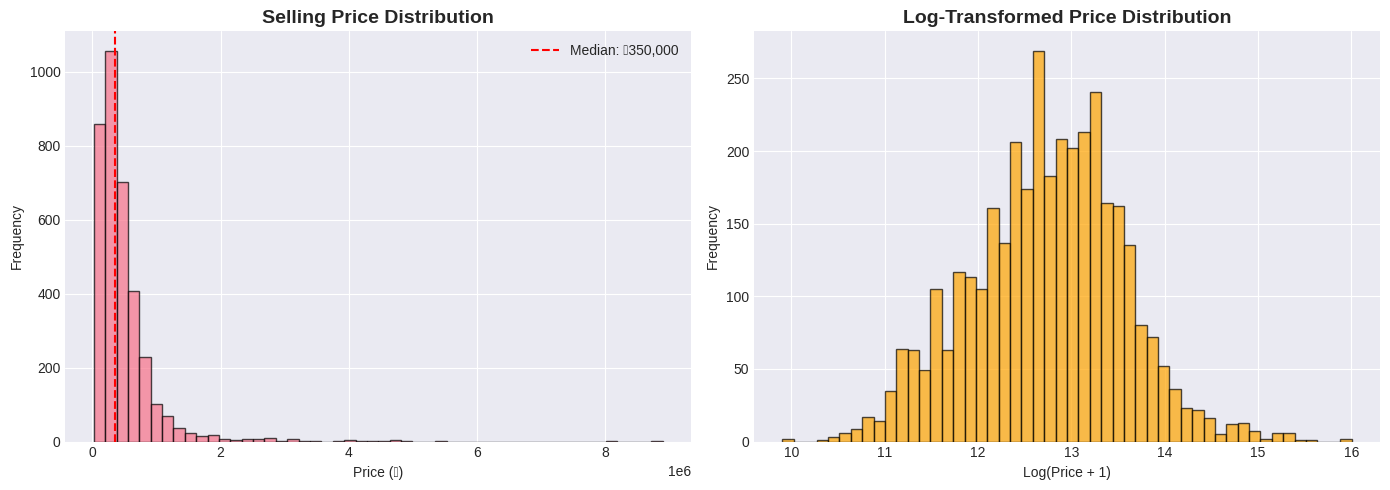

Price Statistics:
   Min: ₹20,000
   Max: ₹8,900,000
   Mean: ₹473,913
   Median: ₹350,000


In [13]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original distribution
axes[0].hist(df['selling_price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Selling Price Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Price (₹)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(df['selling_price'].median(), color='red', linestyle='--', label=f"Median: ₹{df['selling_price'].median():,.0f}")
axes[0].legend()

# Log-transformed distribution
axes[1].hist(np.log1p(df['selling_price']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Log-Transformed Price Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log(Price + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Price Statistics:")
print(f"   Min: ₹{df['selling_price'].min():,.0f}")
print(f"   Max: ₹{df['selling_price'].max():,.0f}")
print(f"   Mean: ₹{df['selling_price'].mean():,.0f}")
print(f"   Median: ₹{df['selling_price'].median():,.0f}")

Advanced Feature Engineering: Creating high-value features that capture domain knowledge:

In [16]:
# Create a copy for feature engineering
df_fe = df.copy()

CURRENT_YEAR = 2025

# 1. Car age
df_fe['car_age'] = CURRENT_YEAR - df_fe['year']

# 2. Extract brand from name
df_fe['brand'] = df_fe['name'].str.split().str[0]

# 3. Encode owner as numeric
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 0
}
df_fe['owner_num'] = df_fe['owner'].map(owner_mapping)

# 4. Price per kilometer (depreciation indicator)
df_fe['price_per_km'] = df_fe['selling_price'] / (df_fe['km_driven'] + 1)

# 5. Luxury brand indicator
luxury_brands = ['Mercedes', 'BMW', 'Audi', 'Jaguar', 'Porsche', 'Land', 'Volvo', 'Lexus']
df_fe['is_luxury'] = df_fe['brand'].isin(luxury_brands).astype(int)

# 6. Popular brand indicator (high volume brands often retain value)
popular_brands = ['Maruti', 'Hyundai', 'Honda', 'Toyota', 'Mahindra']
df_fe['is_popular_brand'] = df_fe['brand'].isin(popular_brands).astype(int)

# 7. Age-kilometer interaction (wear and tear)
df_fe['age_km_interaction'] = df_fe['car_age'] * df_fe['km_driven'] / 1000

# 8. Age squared (non-linear depreciation)
df_fe['age_squared'] = df_fe['car_age'] ** 2

# 9. Kilometers per year (usage intensity)
df_fe['km_per_year'] = df_fe['km_driven'] / (df_fe['car_age'] + 1)

# 10. Fuel-Transmission combination (affects value)
df_fe['fuel_transmission'] = df_fe['fuel'] + '_' + df_fe['transmission']

# 11. High mileage indicator
df_fe['high_mileage'] = (df_fe['km_driven'] > 100000).astype(int)

# 12. Brand popularity score (based on frequency)
brand_counts = df_fe['brand'].value_counts()
df_fe['brand_popularity'] = df_fe['brand'].map(brand_counts)

print("Feature Engineering Complete!")
print(f"\nTotal Features Created: {df_fe.shape[1]}")
print(f"\nNew Features:")
new_features = ['car_age', 'brand', 'owner_num', 'price_per_km', 'is_luxury',
                'is_popular_brand', 'age_km_interaction', 'age_squared',
                'km_per_year', 'fuel_transmission', 'high_mileage', 'brand_popularity']
for feat in new_features:
    print(f"   ✓ {feat}")

Feature Engineering Complete!

Total Features Created: 20

New Features:
   ✓ car_age
   ✓ brand
   ✓ owner_num
   ✓ price_per_km
   ✓ is_luxury
   ✓ is_popular_brand
   ✓ age_km_interaction
   ✓ age_squared
   ✓ km_per_year
   ✓ fuel_transmission
   ✓ high_mileage
   ✓ brand_popularity


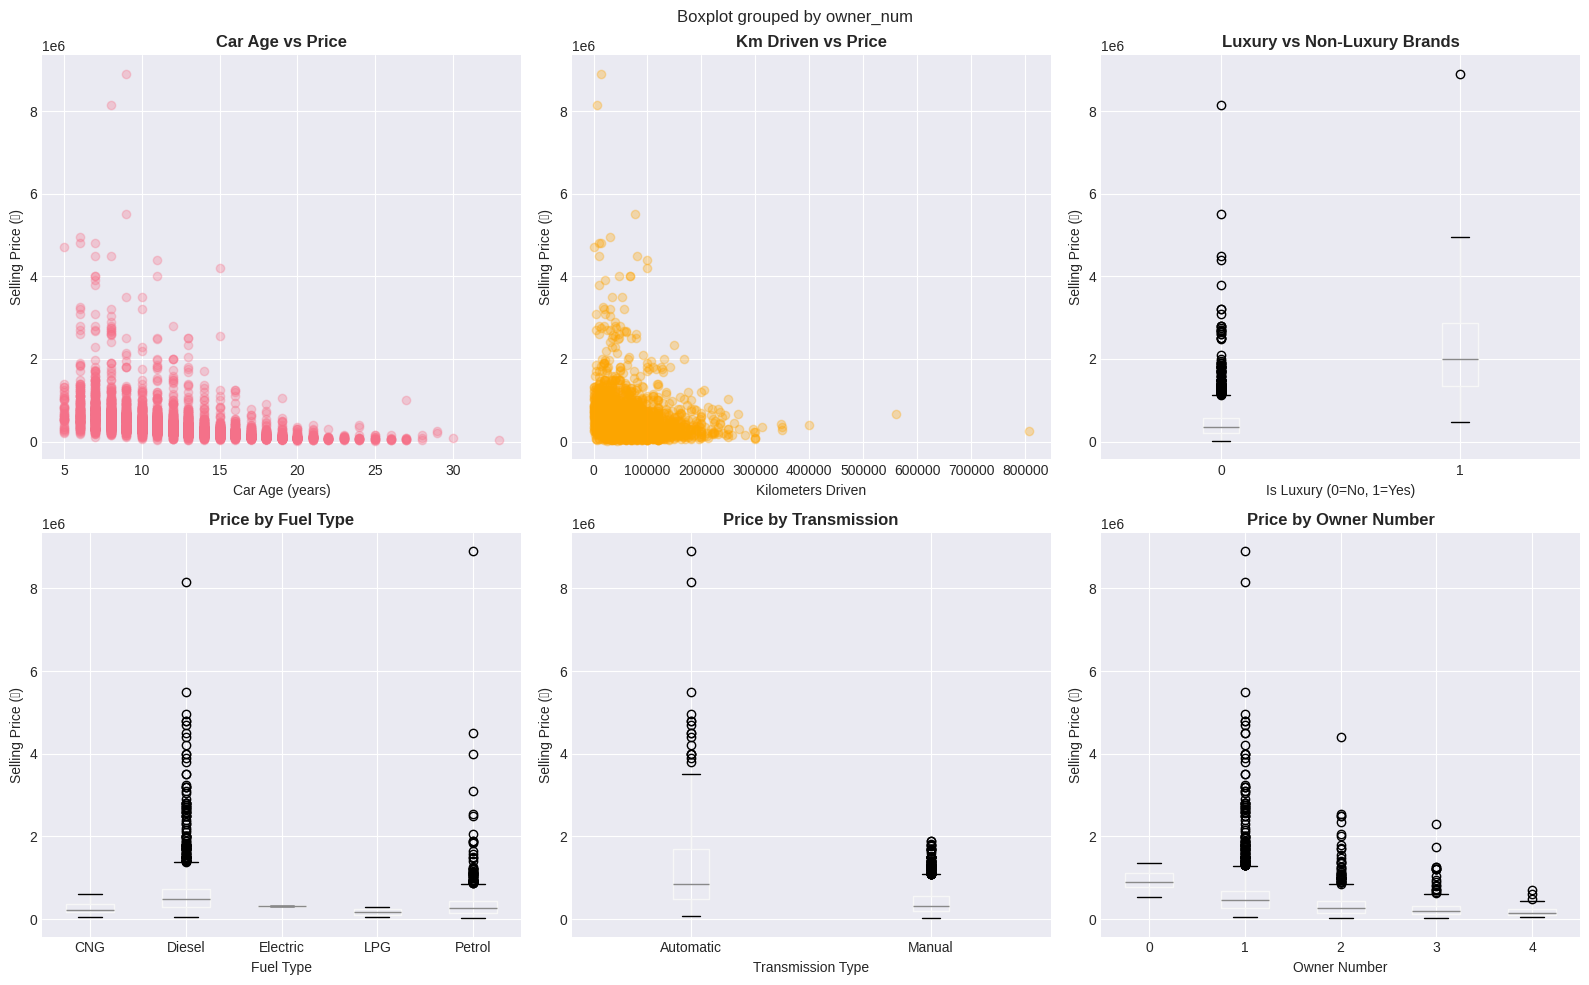

In [17]:
# Visualize key engineered features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Car age vs price
axes[0, 0].scatter(df_fe['car_age'], df_fe['selling_price'], alpha=0.3)
axes[0, 0].set_title('Car Age vs Price', fontweight='bold')
axes[0, 0].set_xlabel('Car Age (years)')
axes[0, 0].set_ylabel('Selling Price (₹)')

# Km driven vs price
axes[0, 1].scatter(df_fe['km_driven'], df_fe['selling_price'], alpha=0.3, color='orange')
axes[0, 1].set_title('Km Driven vs Price', fontweight='bold')
axes[0, 1].set_xlabel('Kilometers Driven')
axes[0, 1].set_ylabel('Selling Price (₹)')

# Luxury vs non-luxury
df_fe.boxplot(column='selling_price', by='is_luxury', ax=axes[0, 2])
axes[0, 2].set_title('Luxury vs Non-Luxury Brands', fontweight='bold')
axes[0, 2].set_xlabel('Is Luxury (0=No, 1=Yes)')
axes[0, 2].set_ylabel('Selling Price (₹)')

# Fuel type
df_fe.boxplot(column='selling_price', by='fuel', ax=axes[1, 0])
axes[1, 0].set_title('Price by Fuel Type', fontweight='bold')
axes[1, 0].set_xlabel('Fuel Type')
axes[1, 0].set_ylabel('Selling Price (₹)')

# Transmission
df_fe.boxplot(column='selling_price', by='transmission', ax=axes[1, 1])
axes[1, 1].set_title('Price by Transmission', fontweight='bold')
axes[1, 1].set_xlabel('Transmission Type')
axes[1, 1].set_ylabel('Selling Price (₹)')

# Owner type
df_fe.boxplot(column='selling_price', by='owner_num', ax=axes[1, 2])
axes[1, 2].set_title('Price by Owner Number', fontweight='bold')
axes[1, 2].set_xlabel('Owner Number')
axes[1, 2].set_ylabel('Selling Price (₹)')

plt.tight_layout()
plt.show()

Data Preprocessing & Train-Test Split

In [19]:
# Drop original columns we don't need
df_model = df_fe.drop(columns=['name', 'owner', 'selling_price', 'price_per_km'], errors='ignore')

# Separate target
y = df_fe['selling_price']

# Identify categorical and numerical columns
categorical_cols = df_model.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_model.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Feature Summary:")
print(f"   Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"   Numerical features ({len(numerical_cols)}): {numerical_cols}")

# Encode categorical variables
df_encoded = df_model.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

Feature Summary:
   Categorical features (5): ['fuel', 'seller_type', 'transmission', 'brand', 'fuel_transmission']
   Numerical features (11): ['year', 'km_driven', 'car_age', 'owner_num', 'is_luxury', 'is_popular_brand', 'age_km_interaction', 'age_squared', 'km_per_year', 'high_mileage', 'brand_popularity']


In [21]:
# Sort by year to simulate temporal validation
df_sorted = pd.concat([df_encoded, y], axis=1).sort_values('year')

X_sorted = df_sorted.drop(columns=['selling_price'])
y_sorted = df_sorted['selling_price']

# 85-15 split
split_idx = int(0.85 * len(df_sorted))

X_train = X_sorted.iloc[:split_idx]
X_test = X_sorted.iloc[split_idx:]
y_train = y_sorted.iloc[:split_idx]
y_test = y_sorted.iloc[split_idx:]

print(f"Train-Test Split Complete!")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Features: {X_train.shape[1]}")
print(f"\nTrain years: {df_sorted.iloc[:split_idx]['year'].min()} - {df_sorted.iloc[:split_idx]['year'].max()}")
print(f"Test years: {df_sorted.iloc[split_idx:]['year'].min()} - {df_sorted.iloc[split_idx:]['year'].max()}")

Train-Test Split Complete!
   Training set: 3040 samples
   Test set: 537 samples
   Features: 16

Train years: 1992 - 2017
Test years: 2017 - 2020


Baseline Models Comparison

In [22]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """Train and evaluate a model"""
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrics
    metrics = {
        'Model': name,
        'Train_R2': r2_score(y_train, y_pred_train),
        'Test_R2': r2_score(y_test, y_pred_test),
        'Train_RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test_RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'Test_MAE': mean_absolute_error(y_test, y_pred_test),
        'Overfit_Gap': r2_score(y_train, y_pred_train) - r2_score(y_test, y_pred_test)
    }

    return metrics, model, y_pred_test

In [24]:
# Initialize baseline models
baseline_models = {
    'LightGBM': LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        random_state=42,
        verbose=-1
    ),
    'XGBoost': XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=7,
        random_state=42,
        tree_method='hist',
        verbosity=0
    ),
    'CatBoost': CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=7,
        random_state=42,
        verbose=False
    ),
    'RandomForest': RandomForestRegressor(
        n_estimators=300,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    )
}

In [28]:
# Train all models
results = []
trained_models = {}
predictions = {}

for name, model in baseline_models.items():
    metrics, trained_model, y_pred = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    results.append(metrics)
    trained_models[name] = trained_model
    predictions[name] = y_pred

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('Test_R2', ascending=False)

print("BASELINE MODELS COMPARISON")
results_df

BASELINE MODELS COMPARISON


,Model,Train_R2,Test_R2,Train_RMSE,Test_RMSE,Test_MAE,Overfit_Gap
1,XGBoost,0.974889,0.655894,70911.144399,390844.054344,241097.484375,0.318995
2,CatBoost,0.925609,0.609454,122051.396084,416383.564375,237783.724741,0.316155
3,RandomForest,0.933974,0.588431,114984.714076,427443.223599,244759.330500,0.345542
0,LightGBM,0.858145,0.582691,168540.386532,430413.654358,264599.224655,0.275454


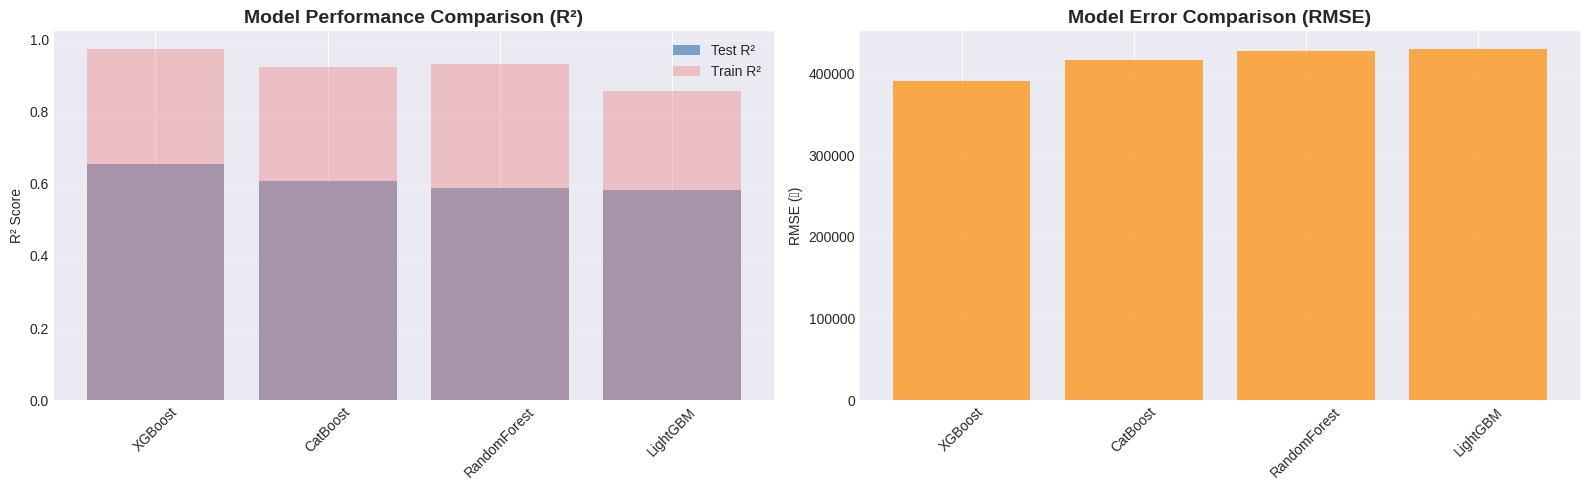


Best Baseline Model: XGBoost
Test R²: 0.6559 (65.59% variance explained)
Test RMSE: ₹390,844
Test MAE: ₹241,097


In [30]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# R² comparison
x_pos = np.arange(len(results_df))
axes[0].bar(x_pos, results_df['Test_R2'], alpha=0.7, color='steelblue', label='Test R²')
axes[0].bar(x_pos, results_df['Train_R2'], alpha=0.4, color='lightcoral', label='Train R²')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['Model'], rotation=45)
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Performance Comparison (R²)', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# RMSE comparison
axes[1].bar(x_pos, results_df['Test_RMSE'], alpha=0.7, color='darkorange')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results_df['Model'], rotation=45)
axes[1].set_ylabel('RMSE (₹)')
axes[1].set_title('Model Error Comparison (RMSE)', fontweight='bold', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Best model
best_model_name = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['Test_R2']
best_rmse = results_df.iloc[0]['Test_RMSE']

print(f"\nBest Baseline Model: {best_model_name}")
print(f"Test R²: {best_r2:.4f} ({best_r2*100:.2f}% variance explained)")
print(f"Test RMSE: ₹{best_rmse:,.0f}")
print(f"Test MAE: ₹{results_df.iloc[0]['Test_MAE']:,.0f}")

Hyperparameter Optimization with Optuna: Fine-tuning the best model using Bayesian optimization

In [32]:
def objective_lgb(trial):
    """Optuna objective function for LightGBM"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbose': -1
    }

    model = LGBMRegressor(**params)

    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(
        model, X_train, y_train,
        cv=kf, scoring='neg_mean_squared_error', n_jobs=-1
    )

    return -scores.mean()

In [34]:
# Run optimization
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42)
)

study.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

print(f"\nBest RMSE: ₹{np.sqrt(study.best_value):,.0f}")
print(f"\nBest Parameters:")
for param, value in study.best_params.items():
    print(f"   {param}: {value}")

  0%|          | 0/50 [00:00<?, ?it/s]


Best RMSE: ₹264,348

Best Parameters:
   n_estimators: 644
   learning_rate: 0.011015035004818754
   max_depth: 5
   num_leaves: 20
   min_child_samples: 5
   subsample: 0.9300909946800912
   colsample_bytree: 0.6819011669870624
   reg_alpha: 0.0014933195645479328
   reg_lambda: 6.972482640183612e-05


In [36]:
# Train final optimized model
best_params = study.best_params
best_params['random_state'] = 42
best_params['verbose'] = -1

optimized_lgb = LGBMRegressor(**best_params)
optimized_lgb.fit(X_train, y_train)

# Evaluate
y_pred_train_opt = optimized_lgb.predict(X_train)
y_pred_test_opt = optimized_lgb.predict(X_test)

opt_metrics = {
    'Train R²': r2_score(y_train, y_pred_train_opt),
    'Test R²': r2_score(y_test, y_pred_test_opt),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train_opt)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_opt)),
    'Test MAE': mean_absolute_error(y_test, y_pred_test_opt)
}

print("OPTIMIZED LightGBM PERFORMANCE")
for metric, value in opt_metrics.items():
    if 'R²' in metric:
        print(f"{metric}: {value:.4f} ({value*100:.2f}%)")
    else:
        print(f"{metric}: ₹{value:,.0f}")

# Compare with baseline
baseline_lgb_r2 = results_df[results_df['Model'] == 'LightGBM']['Test_R2'].values[0]
improvement = ((opt_metrics['Test R²'] - baseline_lgb_r2) / baseline_lgb_r2) * 100

print(f"\nImprovement over baseline: {improvement:+.2f}%")

OPTIMIZED LightGBM PERFORMANCE
Train R²: 0.8778 (87.78%)
Test R²: 0.5875 (58.75%)
Train RMSE: ₹156,404
Test RMSE: ₹427,932
Test MAE: ₹256,811

Improvement over baseline: +0.82%


Ensemble Stacking (Advanced): Combining multiple models for superior performance:

In [38]:
# Create stacking ensemble
base_models = [
    ('lgb_optimized', optimized_lgb),
    ('xgb', trained_models['XGBoost']),
    ('cat', trained_models['CatBoost']),
    ('rf', trained_models['RandomForest'])
]

# Meta-learner
meta_model = Ridge(alpha=1.0)

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train, y_train)

# Evaluate
y_pred_stack_train = stacking_model.predict(X_train)
y_pred_stack_test = stacking_model.predict(X_test)

stack_metrics = {
    'Train R²': r2_score(y_train, y_pred_stack_train),
    'Test R²': r2_score(y_test, y_pred_stack_test),
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_stack_train)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_stack_test)),
    'Test MAE': mean_absolute_error(y_test, y_pred_stack_test)
}

print("STACKING ENSEMBLE PERFORMANCE")
for metric, value in stack_metrics.items():
    if 'R²' in metric:
        print(f"{metric}: {value:.4f} ({value*100:.2f}%)")
    else:
        print(f"{metric}: ₹{value:,.0f}")

# Final improvement
final_improvement = ((stack_metrics['Test R²'] - baseline_lgb_r2) / baseline_lgb_r2) * 100
print(f"Total improvement over baseline: {final_improvement:+.2f}%")

STACKING ENSEMBLE PERFORMANCE
Train R²: 0.9204 (92.04%)
Test R²: 0.5155 (51.55%)
Train RMSE: ₹126,214
Test RMSE: ₹463,758
Test MAE: ₹261,045
Total improvement over baseline: -11.53%


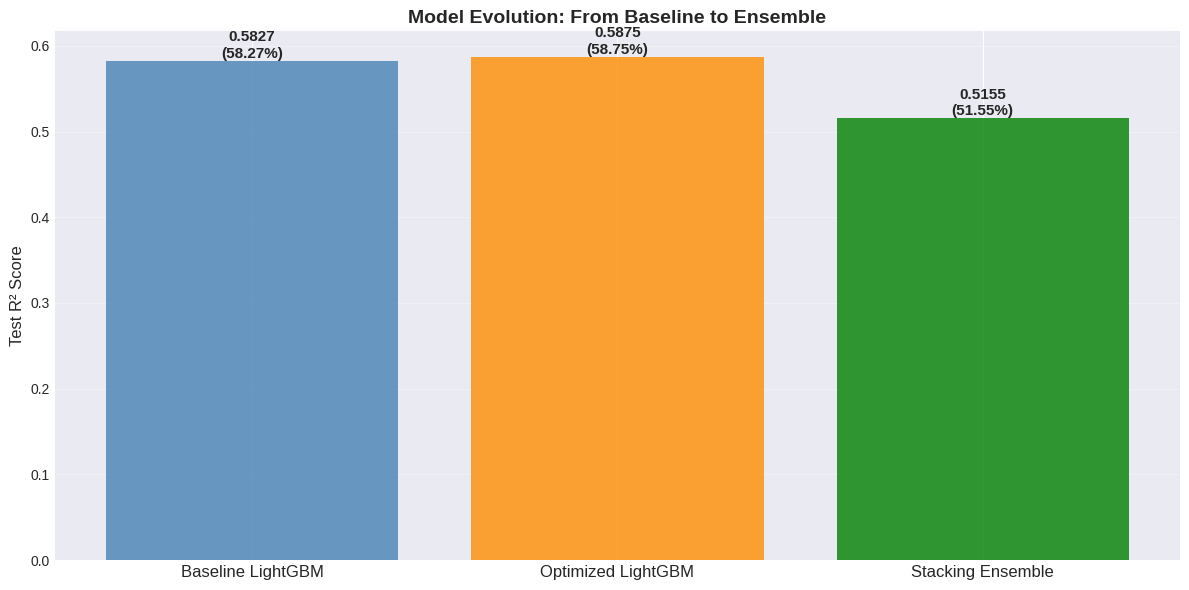


Final Comparison:


,Model,Test R²,Test RMSE
0,Baseline LightGBM,0.582691,430413.654358
1,Optimized LightGBM,0.587490,427931.710248
2,Stacking Ensemble,0.515528,463758.373458


In [39]:
# Final model comparison
final_comparison = pd.DataFrame([
    {
        'Model': 'Baseline LightGBM',
        'Test R²': baseline_lgb_r2,
        'Test RMSE': results_df[results_df['Model'] == 'LightGBM']['Test_RMSE'].values[0]
    },
    {
        'Model': 'Optimized LightGBM',
        'Test R²': opt_metrics['Test R²'],
        'Test RMSE': opt_metrics['Test RMSE']
    },
    {
        'Model': 'Stacking Ensemble',
        'Test R²': stack_metrics['Test R²'],
        'Test RMSE': stack_metrics['Test RMSE']
    }
])

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(final_comparison))

bars = ax.bar(x_pos, final_comparison['Test R²'], alpha=0.8,
              color=['steelblue', 'darkorange', 'green'])
ax.set_xticks(x_pos)
ax.set_xticklabels(final_comparison['Model'], fontsize=12)
ax.set_ylabel('Test R² Score', fontsize=12)
ax.set_title('Model Evolution: From Baseline to Ensemble', fontweight='bold', fontsize=14)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (bar, r2) in enumerate(zip(bars, final_comparison['Test R²'])):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{r2:.4f}\n({r2*100:.2f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nFinal Comparison:")
final_comparison

Model Interpretability with SHAP: Understanding what drives predictions

In [41]:
# Use optimized LightGBM for SHAP (faster than ensemble)
# Create explainer
explainer = shap.TreeExplainer(optimized_lgb)

# Calculate SHAP values for test set (sample for speed)
sample_size = min(1000, len(X_test))
X_test_sample = X_test.iloc[:sample_size]
shap_values = explainer.shap_values(X_test_sample)

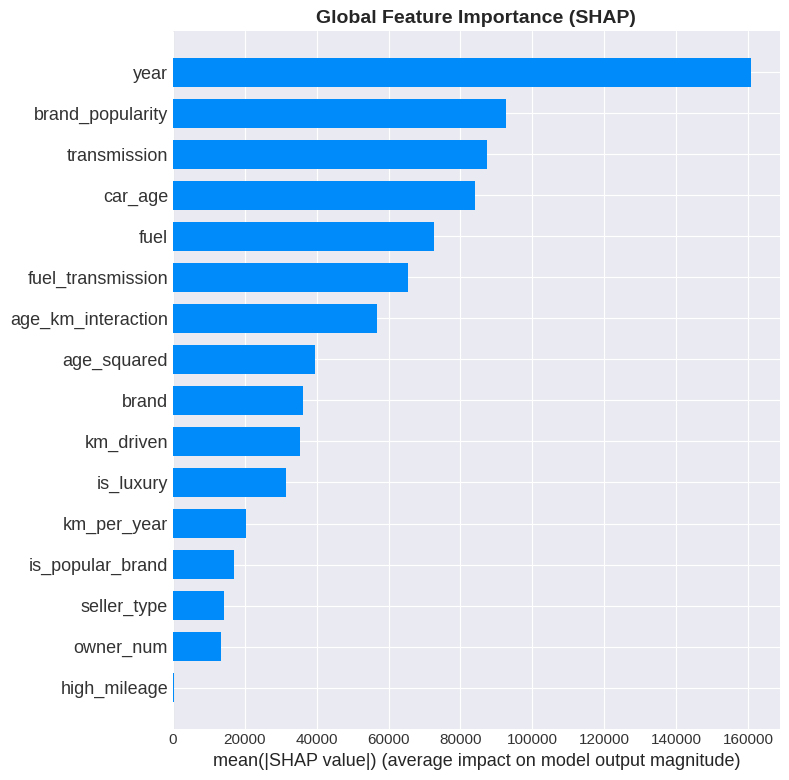

In [42]:
# Global feature importance
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title('Global Feature Importance (SHAP)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

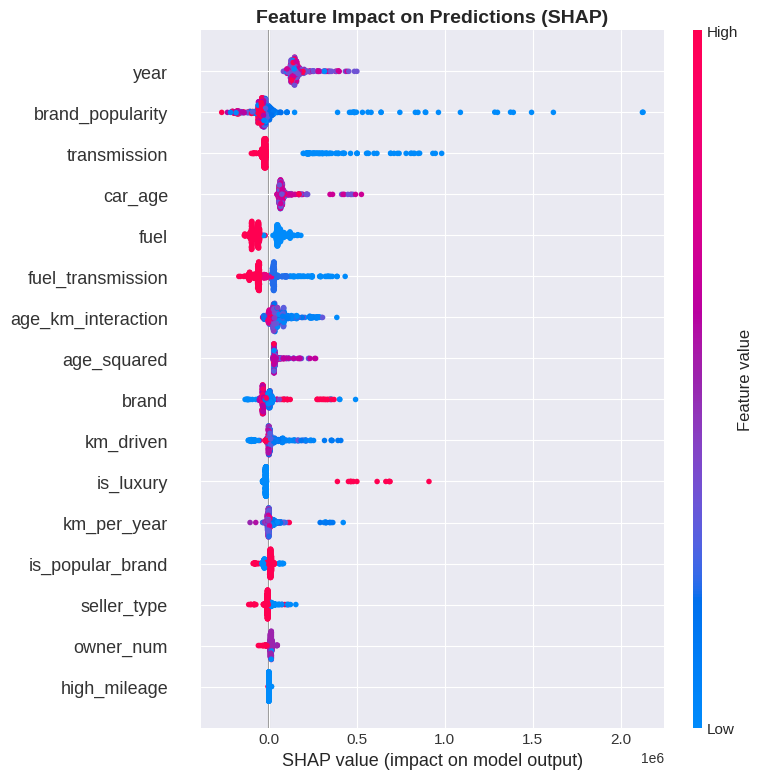

In [43]:
# SHAP summary plot (feature impact)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title('Feature Impact on Predictions (SHAP)', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

Explaining prediction for sample 0:
   Actual price: ₹1,044,999
   Predicted price: ₹814,358
   Error: ₹230,641


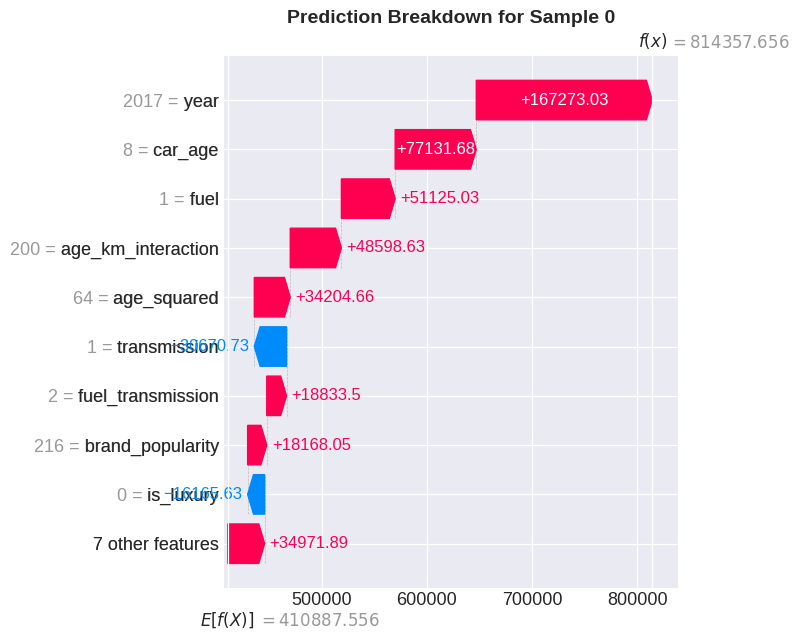

In [45]:
# Individual prediction explanation (waterfall plot)
sample_idx = 0

print(f"Explaining prediction for sample {sample_idx}:")
print(f"   Actual price: ₹{y_test.iloc[sample_idx]:,.0f}")
print(f"   Predicted price: ₹{y_pred_test_opt[sample_idx]:,.0f}")
print(f"   Error: ₹{abs(y_test.iloc[sample_idx] - y_pred_test_opt[sample_idx]):,.0f}")

# Create waterfall plot
shap.plots.waterfall(shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_test_sample.iloc[sample_idx],
    feature_names=X_test_sample.columns.tolist()
), show=False)

plt.title(f'Prediction Breakdown for Sample {sample_idx}', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

Error Analysis & Residual Diagnostics

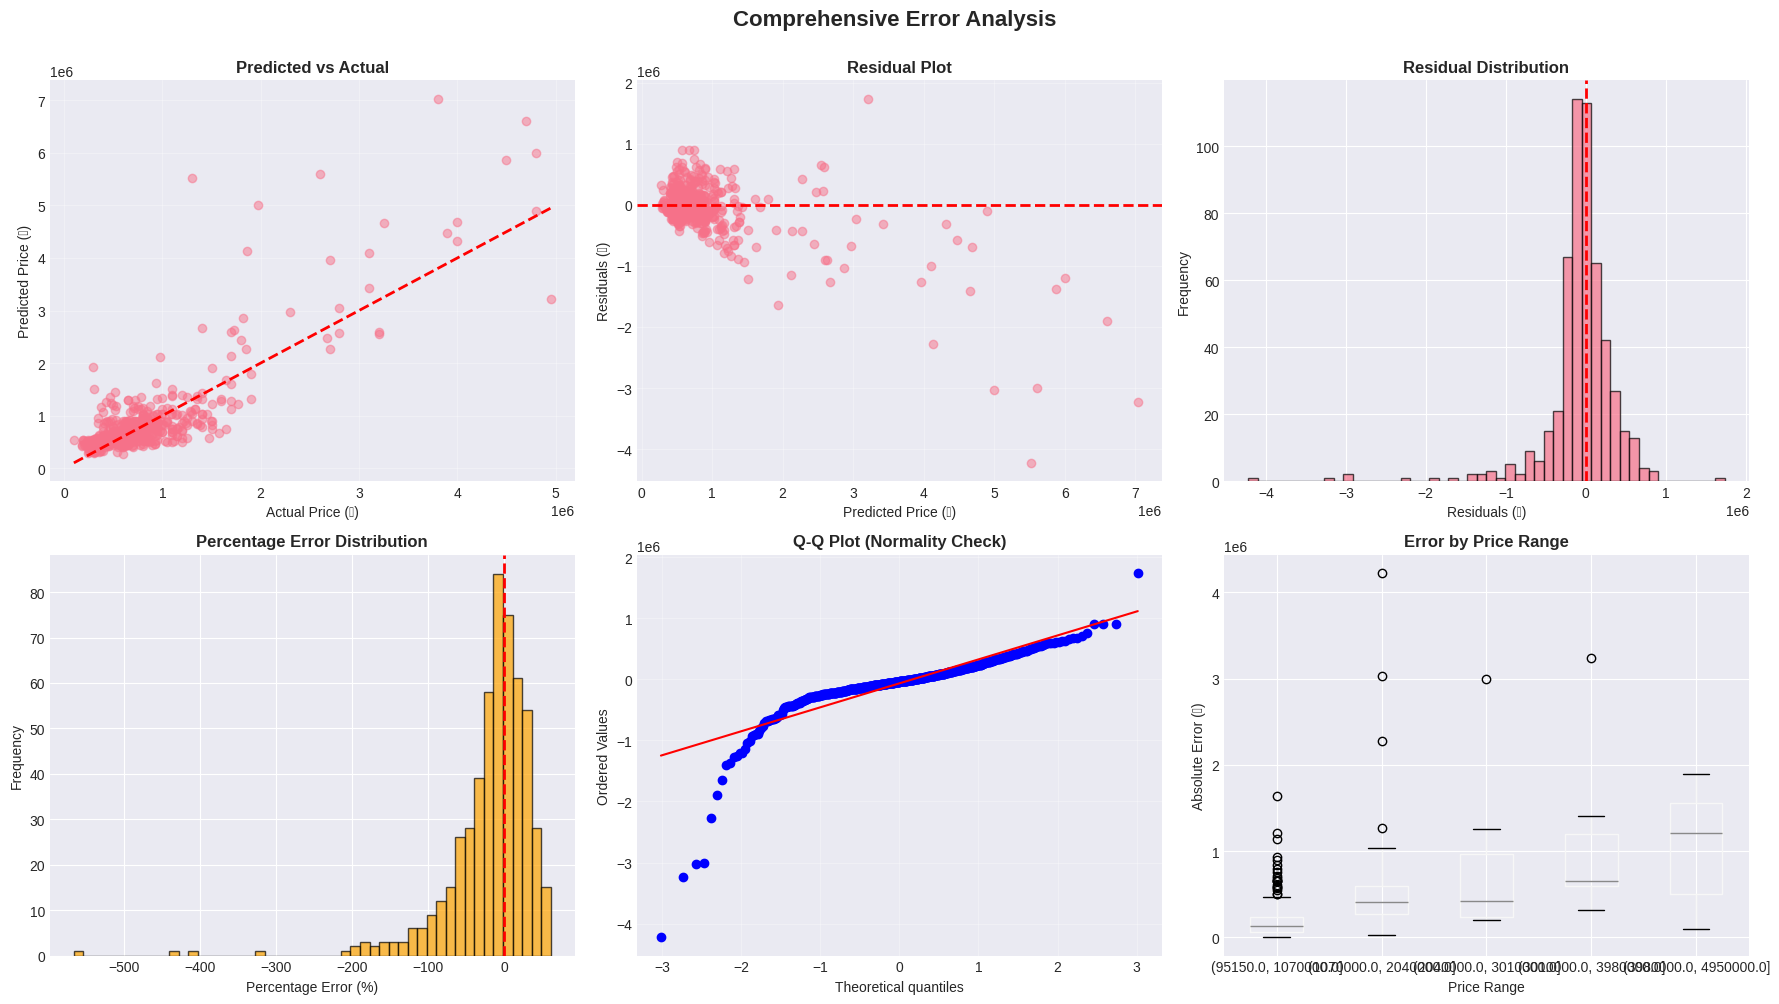

In [46]:
# Calculate residuals (using stacking ensemble)
residuals = y_test.values - y_pred_stack_test
pct_errors = (residuals / y_test.values) * 100

# Create comprehensive error analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Predicted vs Actual
axes[0, 0].scatter(y_test, y_pred_stack_test, alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Price (₹)')
axes[0, 0].set_ylabel('Predicted Price (₹)')
axes[0, 0].set_title('Predicted vs Actual', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2. Residual plot
axes[0, 1].scatter(y_pred_stack_test, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price (₹)')
axes[0, 1].set_ylabel('Residuals (₹)')
axes[0, 1].set_title('Residual Plot', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# 3. Residual distribution
axes[0, 2].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].axvline(x=0, color='r', linestyle='--', lw=2)
axes[0, 2].set_xlabel('Residuals (₹)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Residual Distribution', fontweight='bold')

# 4. Percentage error distribution
axes[1, 0].hist(pct_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Percentage Error (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Percentage Error Distribution', fontweight='bold')

# 5. Q-Q plot
from scipy import stats as sp_stats
sp_stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Check)', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# 6. Error by price range
price_bins = pd.cut(y_test, bins=5)
error_by_bin = pd.DataFrame({'price_bin': price_bins, 'abs_error': np.abs(residuals)})
error_by_bin.boxplot(column='abs_error', by='price_bin', ax=axes[1, 2])
axes[1, 2].set_xlabel('Price Range')
axes[1, 2].set_ylabel('Absolute Error (₹)')
axes[1, 2].set_title('Error by Price Range', fontweight='bold')

plt.suptitle('Comprehensive Error Analysis', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [47]:
# Error statistics
print("Error Statistics:")
print(f"   Mean Residual: ₹{residuals.mean():,.0f}")
print(f"   Std Residual: ₹{residuals.std():,.0f}")
print(f"   Median Absolute Error: ₹{np.median(np.abs(residuals)):,.0f}")
print(f"\nPercentage Error:")
print(f"   Mean: {pct_errors.mean():.2f}%")
print(f"   Median: {np.median(pct_errors):.2f}%")
print(f"   Within ±10%: {(np.abs(pct_errors) <= 10).sum() / len(pct_errors) * 100:.2f}%")
print(f"   Within ±20%: {(np.abs(pct_errors) <= 20).sum() / len(pct_errors) * 100:.2f}%")
print(f"   Within ±30%: {(np.abs(pct_errors) <= 30).sum() / len(pct_errors) * 100:.2f}%")

Error Statistics:
   Mean Residual: ₹-66,820
   Std Residual: ₹458,919
   Median Absolute Error: ₹160,004

Percentage Error:
   Mean: -17.79%
   Median: -5.47%
   Within ±10%: 23.84%
   Within ±20%: 44.13%
   Within ±30%: 59.03%


In [48]:
# Identify worst predictions
error_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred_stack_test,
    'error': residuals,
    'abs_error': np.abs(residuals),
    'pct_error': pct_errors
})

print("\nTop 10 Worst Predictions:")
worst_predictions = error_df.nlargest(10, 'abs_error')
worst_predictions[['actual', 'predicted', 'error', 'pct_error']]


Top 10 Worst Predictions:


,actual,predicted,error,pct_error
413,1300000,5.524234e+06,-4.224234e+06,-324.941091
124,3800000,7.035178e+06,-3.235178e+06,-85.136262
253,1975000,5.002675e+06,-3.027675e+06,-153.299999
410,2600000,5.601374e+06,-3.001374e+06,-115.437442
372,1860000,4.138555e+06,-2.278555e+06,-122.502937
519,4700000,6.598549e+06,-1.898549e+06,-40.394668
446,4950000,3.211287e+06,1.738713e+06,35.125520
201,290000,1.931207e+06,-1.641207e+06,-565.933293
407,3256000,4.662539e+06,-1.406539e+06,-43.198362
252,4500000,5.874432e+06,-1.374432e+06,-30.542941
